#### Script to create time series of various variables from WRF output, only masking domain edges.

James Ruppert  
jruppert@ou.edu  
6/23/23

In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
# matplotlib.use('pdf')
import matplotlib.pyplot as plt
import subprocess
import sys
# from mask_tc_track import mask_tc_track
import pandas as pd
from precip_class import precip_class
from cfads_functions import mask_edges

In [8]:
# #### Main settings

# NOTE: Using copied tracking from CTL for NCRF tests

# #### Variable selection

storm = 'haiyan'
# storm = 'maria'

# How many members
nmem = 10 # number of ensemble members
# nmem = 2

# Variable
varnames=['pw']

# TC tracking
# ptrack='600' # tracking pressure level
# var_track = 'rvor' # variable
# # rmax = 6 # radius (deg) limit for masking around TC center
# rmax = 3 # radius (deg) limit for masking around TC center

# Strat/Conv index subset
# istrat_all=[0,1,2] # 0-non-raining, 1-conv, 2-strat, 3-other/anvil, (-1 for off)
nrain=9 # np.size(istrat_all)
krain_label = \
    ['non-precip', # kstrat=0
    'deepc',    # kstrat=1
    'cong',     # kstrat=2
    'shall',    # kstrat=3
    'strat',    # kstrat=4
    'anvil',    # kstrat=5
    'deepcong', # deep + cong
    'stratanv', # strat + anv  
    'allrain']  # deep + cong + strat + anv

krain_title = \
    ['Non Precip',
    'Deep Conv',
    'Congestus',
    'Shallow',
    'Stratiform',
    'Anvil',
    'Deep + Congestus',
    'Strat + Anvil',  
    'Dp + Cg + St + An']

# #### Directories

figdir = "/home/jamesrup/figures/tc/ens/time_series/"
main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"

# Tests to read and compare
ntest=2
if storm == 'haiyan':
    tests = ['ctl','ncrf36h']
elif storm == 'maria':
#        tests = ['ctl','ncrf36h']
    tests = ['ctl','ncrf48h']

In [3]:
def get_tshift(itest):
    if itest == 'ctl':
        tshift=0
    elif itest == 'ncrf36h':
        tshift=36
    elif itest == 'ncrf48h':
        tshift=48
    return tshift

# Ens member strings
memb0=1 # Starting member to read
nums=np.arange(memb0,nmem+memb0,1)
nums=nums.astype(str)
nustr = np.char.zfill(nums, 2)
memb_all=np.char.add('memb_',nustr)

# Get Lat/Lon
# datdir = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/'
# process = subprocess.Popen(['ls '+datdir+'/wrfout_d02_*'],shell=True,
#     stdout=subprocess.PIPE,universal_newlines=True)
# output = process.stdout.readline()
# wrffil = output.strip() #[3]
# varfil_main = Dataset(wrffil)
# lat = varfil_main.variables['XLAT'][:][0] # deg
# lon = varfil_main.variables['XLONG'][:][0] # deg
# varfil_main.close()
# lon1d=lon[0,:]
# lat1d=lat[:,0]

nt = np.zeros(ntest, dtype=np.int32)
for itest in range(ntest):
    ##### Get dimensions
    datdir = main+storm+'/'+memb_all[0]+'/'+tests[itest]+'/'
    varfil_main = Dataset(datdir+'post/d02/T.nc')
    i_nt = varfil_main.dimensions['time'].size
    varfil_main.close()
    nt[itest]=i_nt

In [4]:
##### FUNCTIONS ############################################################

def var_read(filename, varname):
    varfil_main = Dataset(filename)
    var = varfil_main.variables[varname][:,:,:,:]
    varfil_main.close()
    return var

def plot_rainhist(x):
    n, bins, patches = plt.hist(x, 500, density=True, facecolor='g', alpha=0.75)
    plt.xlabel('mm/hr')
    plt.ylabel('Occurrence')
    plt.title('Rainfall Rate Distribution')
    plt.xlim(0.1, 80)
    # plt.ylim(0, 0.03)
    # plt.grid(True)
    # plt.show()

In [7]:
# Create arrays

# Time index set based on TEST 0 (e.g., CTL)
var_sav = np.empty((ntest,nmem,nrain,nt[0]))
var_sav[:]=np.nan

# #### Main loops

for ivar in varnames:

    print('Running VAR: ',ivar)

    for itest in range(ntest):
    # for itest in range(1):

        print('Running test: ',tests[itest])

        for imemb in range(nmem):

            print('Running imemb: ',memb_all[imemb])

            datdir = main+storm+'/'+memb_all[imemb]+'/'+tests[itest]+'/'
            # track_file = datdir+'track_'+var_track+'_'+ptrack+'hPa.nc'
            # Localize to TC track
            # NOTE: Using copied tracking from CTL for NCRF tests
            # trackfil_ex=''
            # if 'ncrf' in tests[itest]:
            #     trackfil_ex='_ctlcopy'
            # track_file = datdir+'track_'+var_track+trackfil_ex+'_'+ptrack+'hPa.nc'

            # Read variables

            datdir = main+storm+'/'+memb_all[imemb]+'/'+tests[itest]+'/post/d02/'
            print(datdir)

            # Strat
            # varfil_main = Dataset(datdir+'strat.nc')
            # strat = varfil_main.variables['strat'][:,0,:,:] # 0-non-raining, 1-conv, 2-strat, 3-other/anvil
            # varfil_main.close()
            
            # New classification scheme
            q_int = var_read(datdir+'q_int.nc', 'q_int')
            strat = precip_class(q_int)

            # Main variable
            if ivar == 'pw':
                var = var_read(datdir+'PW.nc', 'PW')
            var = np.squeeze(var)
            
            t0=0
            t1=nt[itest]

            # Mask out around TC center
            # rain = mask_tc_track(track_file, rmax, rain, lon, lat, t0, t1)
            # rain = np.ma.filled(rain, fill_value=np.nan)
            # strat = mask_tc_track(track_file, rmax, strat, lon, lat, t0, t1)
            # strat = np.ma.filled(strat, fill_value=np.nan)
            # grad_s = mask_tc_track(track_file, rmax, grad_s[:,np.newaxis,:,:], lon, lat, t0, t1)
            # grad_s = np.ma.filled(grad_s, fill_value=np.nan)
            # grad_h = mask_tc_track(track_file, rmax, grad_h[:,np.newaxis,:,:], lon, lat, t0, t1)
            # grad_h = np.ma.filled(grad_h, fill_value=np.nan)

            # Mask out domain-edges
            strat = mask_edges(strat)
            var = mask_edges(var)

            # Loop over time and average over specific points

            tshift = get_tshift(tests[itest])

            for it in range(nt[itest]):
                for krain in range(nrain):

                    strat_it = strat[it]

                    if krain <= 5:
                        ind_rain = (strat_it == krain).nonzero()
                    elif krain == 6:
                    # deep + cong
                        ind_rain = ((strat_it == 1) | (strat_it == 2)).nonzero()
                    elif krain == 7:
                    # strat + anv
                        ind_rain = ((strat_it == 4) | (strat_it == 5)).nonzero()
                    elif krain == 8:
                    # deep + cong + strat + anv
                        ind_rain = ((strat_it == 1) | (strat_it == 2) | (strat_it == 4) | (strat_it == 5)).nonzero()

                    # Jump time step if too few points found
                    if np.size(ind_rain[0]) < 4: continue

                    var_avg = np.nanmean(var[it,ind_rain[0],ind_rain[1]])

                    var_sav[itest,imemb,krain,it+tshift] = var_avg

Running VAR:  pw
Running test:  ctl
Running imemb:  memb_01
/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/haiyan/memb_01/ctl/post/d02/
Running imemb:  memb_02
/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/haiyan/memb_02/ctl/post/d02/
Running imemb:  memb_03
/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/haiyan/memb_03/ctl/post/d02/
Running imemb:  memb_04
/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/haiyan/memb_04/ctl/post/d02/
Running imemb:  memb_05
/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/haiyan/memb_05/ctl/post/d02/
Running imemb:  memb_06
/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/haiyan/memb_06/ctl/post/d02/
Running imemb:  memb_07
/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/haiyan/memb_07/ctl/post/d02/
Running imemb:  memb_08
/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/haiyan/memb_08/ctl/post/d02/
Running imemb:  memb_09
/ourdisk/hpc

/tmp/ipykernel_43549/1729426479.py:67: RuntimeWarning: Mean of empty slice
  mean_t0 = np.nanmean(var0, axis=0)
/tmp/ipykernel_43549/1729426479.py:83: RuntimeWarning: Mean of empty slice
  mean_t1 = np.nanmean(var1, axis=0)


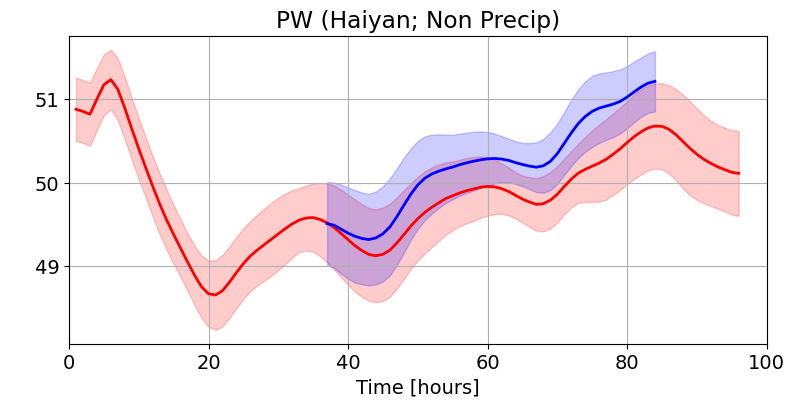

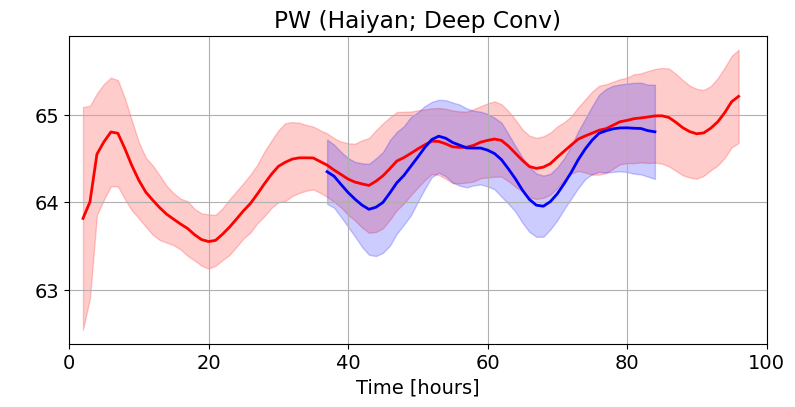

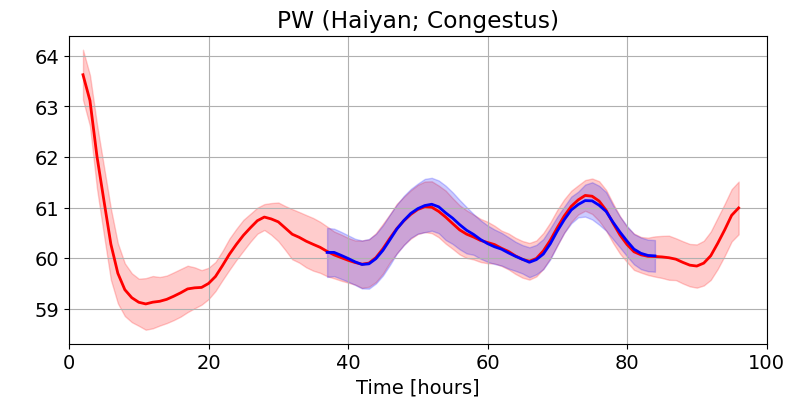

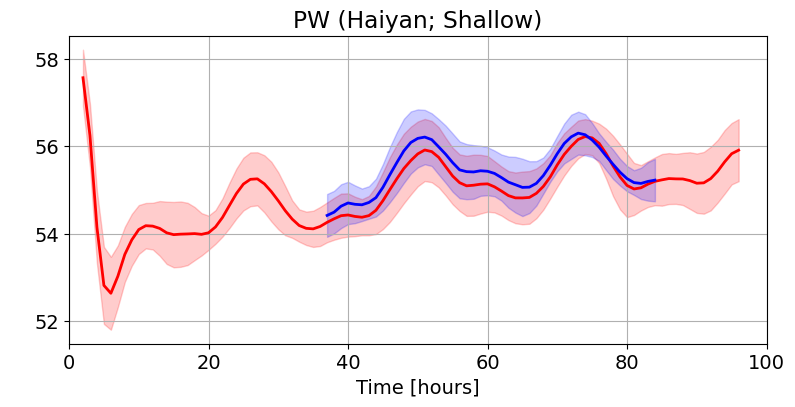

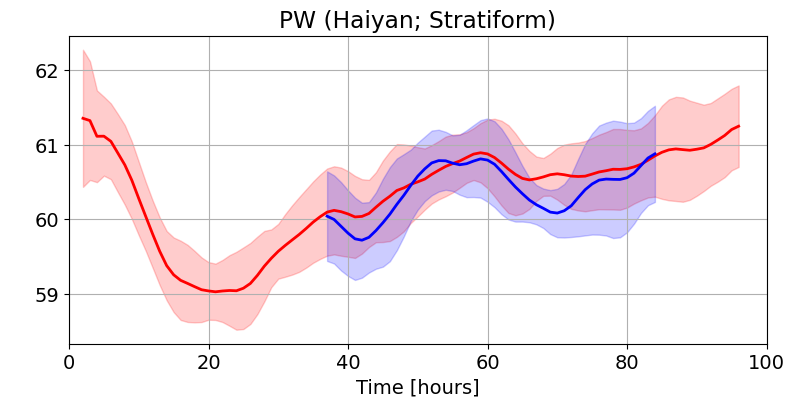

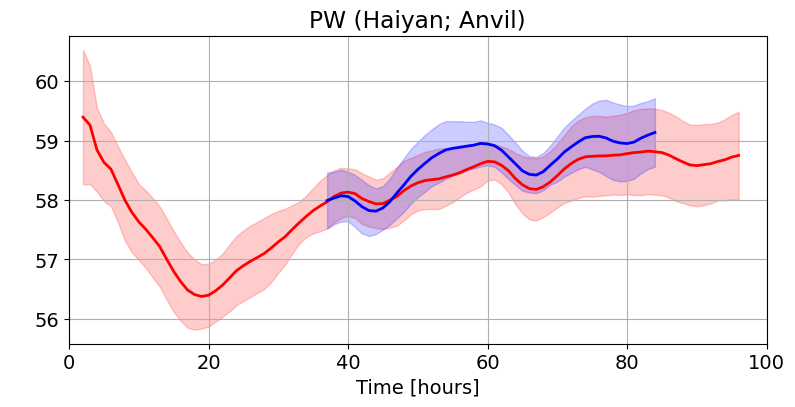

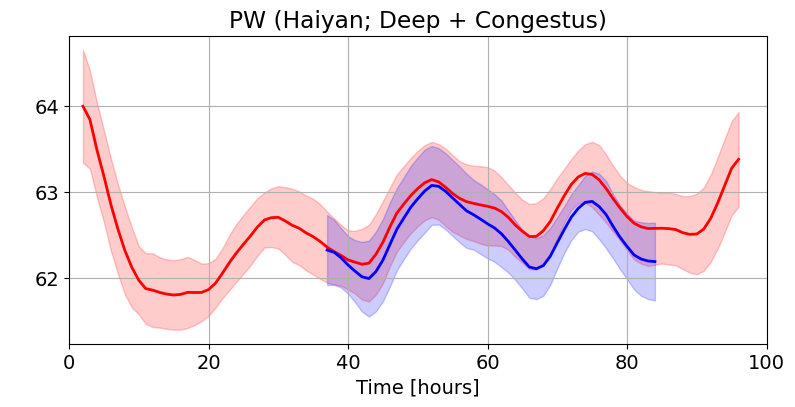

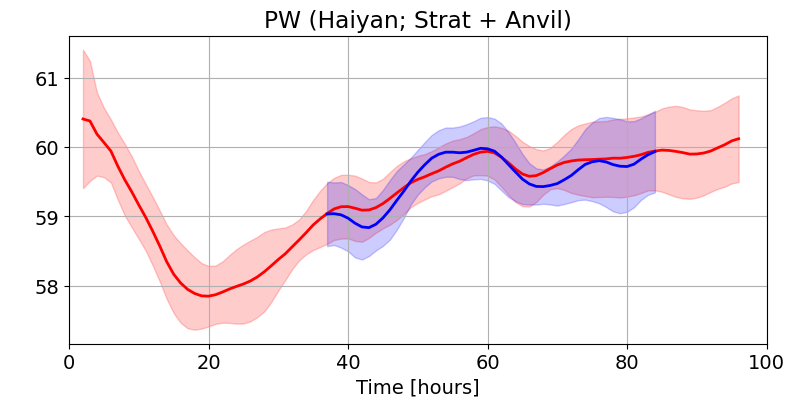

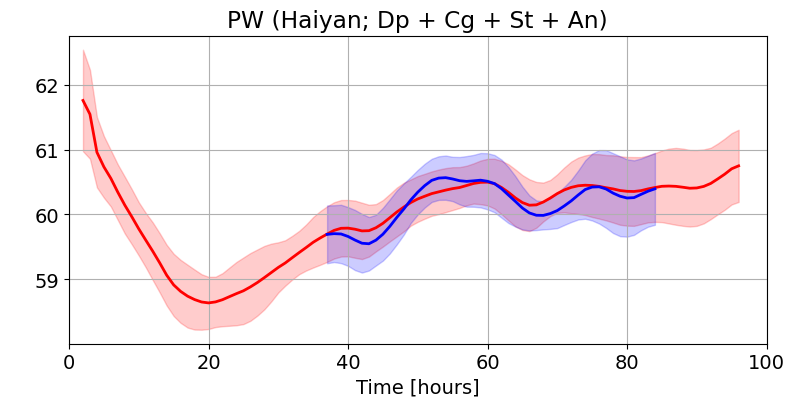

In [12]:
# ### Plotting routines

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)


for krain in range(nrain):
# for krain in range(1):

    fig_extra=krain_label[krain]
    raintag=krain_title[krain]

    var0 = var_sav[0,:,krain,:]
    var1 = var_sav[1,:,krain,:]

    for ivar in varnames:

        if ivar == 'pw':
            var0 = np.copy(var0)
            var1 = np.copy(var1)
            title_tag = 'PW'
            figtag = ivar
        # elif ivar == 1:

    #----------------------------------------------------------------

        var0 = pd.DataFrame(var0)
        var0 = var0.rolling(window=3, center=True, closed='both', axis=1).mean()
        var0 = np.copy(var0)

        var1 = pd.DataFrame(var1)
        var1 = var1.rolling(window=3, center=True, closed='both', axis=1).mean()
        var1 = np.copy(var1)

        # create figure
        fig = plt.figure(figsize=(9,4))
        ax = fig.add_subplot(111)

        ax.set_title(title_tag+' ('+storm.capitalize()+'; '+raintag+')')#, fontsize=20)
        ax.set_ylabel(' ')
        ax.set_xlabel('Time [hours]')

        if (ivar == 0):
            plt.ylim([-1,1])
            # if (krain ==2):
            #     plt.ylim([-1.5,-.5])
            # else:
            #     plt.ylim([-.5,.5])
        if (ivar == 5):
            if (krain == 2): plt.ylim([-50,50])

        t_range=[30,80]
        t_range=[0,100]
        if storm == 'maria':
            t_range=[40,90]

        plt.xlim(t_range)

        color_t0 = 'red'
        color_t1 = 'blue'

        # Test 0

        mean_t0 = np.nanmean(var0, axis=0)
        std_t0 = np.nanstd(var0, axis=0)

        # tshift = get_tshift(tests[0])
        # xdim = range(0+tshift, nt[0]+tshift)
        xdim = range(nt[0])

        # for imemb in range(nmem):
        #     plt.plot(xdim, var0[imemb,:], linewidth=2, label=tests[0].upper(), color=color_t0, linestyle='solid')
        # print("xdim: ",xdim)
        # print("meant0: ",mean_t0.shape)
        plt.plot(xdim, mean_t0, linewidth=2, label=tests[0].upper(), color=color_t0, linestyle='solid')
        plt.fill_between(xdim, mean_t0 + std_t0, mean_t0 - std_t0, alpha=0.2, color=color_t0)

        # Test 1

        mean_t1 = np.nanmean(var1, axis=0)
        std_t1 = np.nanstd(var1, axis=0)

        # tshift = get_tshift(tests[1])
        # xdim = range(0+tshift, nt[1]+tshift)

        # for imemb in range(nmem):
        #     plt.plot(xdim, var1[imemb,:], linewidth=2, label=tests[0].upper(), color=color_t1, linestyle='solid')
        # print("xdim: ",xdim)
        # print("meant1: ",mean_t1.shape)
        plt.plot(xdim, mean_t1, linewidth=2, label=tests[0].upper(), color=color_t1, linestyle='solid')
        plt.fill_between(xdim, mean_t1 + std_t1, mean_t1 - std_t1, alpha=0.2, color=color_t1)

        plt.grid()

        # plt.legend(loc="upper right")

        # rmax_str = str(rmax)
        # figdir2 = figdir+rmax_str+'deg/'
        figdir2 = figdir+'all/'
        # figname=figdir2+'tser_'+storm+'_'+figtag+'_'+fig_extra+'_rmax'+rmax_str+'deg.png'
        figname=figdir2+'tser_'+storm+'_'+figtag+'_'+fig_extra+'.png'
        plt.savefig(figname,dpi=200, facecolor='white', \
                    bbox_inches='tight', pad_inches=0.2)
        plt.show()
        plt.close()